In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/github/low-dimensional-hsi')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.insert(0, './models')

In [3]:
import tensorflow as tf
import numpy as np
import scipy.io as sio

from utils import *
from models.Alpha8L import *
from matplotlib import pyplot as plt
from admm import ADMM as algADMM

In [4]:
RGB = [22, 12, 4]
h = sio.loadmat('./data/kaist1.mat')['img']
h = np.expand_dims(h,0)         
Batch_size, Img_heigth , Img_width , Channels = h.shape                
coded_aperture = np.load('ca.npy')

y = dd_cassi(h,coded_aperture)

In [5]:
print(coded_aperture.shape)

(1, 512, 542, 1, 1)


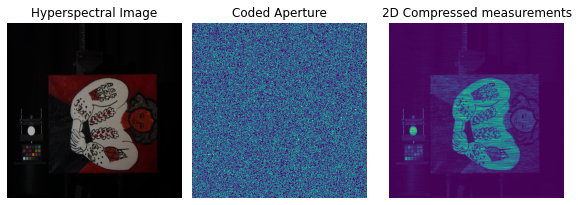

In [6]:
fig, axs = plt.subplots(1,3,constrained_layout=True , figsize=(8,3))
_ = [ x.axis('Off') for x in axs]

axs[0].imshow(h[0,:,:,:][:,:,RGB]) , axs[0].set_title('Hyperspectral Image')
axs[1].imshow(coded_aperture[0,:,:,0,0], aspect=1.06) , axs[1].set_title('Coded Aperture')
axs[2].imshow(y[0,:,:,0]), axs[2].set_title('2D Compressed measurements')
plt.show()

In [7]:
input_size = (Img_heigth, Img_width, Channels)
weights = './weights/Alpha8L_Kaist.h5'

In [8]:
optimizad = tf.keras.optimizers.Adam(learning_rate=1e-4)

main_model = HSI_net(coded_aperture, input_size=input_size,  pretrained_weights=weights)

autoencoder = main_model.autoencoder
encode = main_model.encoder
decode = main_model.decoder

autoencoder.compile(optimizer=optimizad, loss='mean_squared_error')
encode.compile(optimizer=optimizad, loss='mean_squared_error')
decode.compile(optimizer=optimizad, loss='mean_squared_error')

In [9]:
algorit_admm = algADMM(main_model)
epochs , steps = 200 , 20
params = [1 , 0.1 , 0.3]

In [10]:
h_est = algorit_admm(y,epochs,steps,params)

||temp-t_old||152.49285352484702||temp2-t2_old||216.21115120458998
||temp-t_old||27.276917||temp2-t2_old||29.796076
||temp-t_old||15.274914||temp2-t2_old||17.966955
||temp-t_old||7.680391||temp2-t2_old||12.125918
||temp-t_old||5.093396||temp2-t2_old||8.187338
||temp-t_old||3.8537397||temp2-t2_old||5.700127
||temp-t_old||3.2251854||temp2-t2_old||4.125876
||temp-t_old||2.8175347||temp2-t2_old||2.9183636
||temp-t_old||2.6032739||temp2-t2_old||2.174987
||temp-t_old||2.511583||temp2-t2_old||1.7245127
||temp-t_old||2.4927037||temp2-t2_old||1.4094075
||temp-t_old||2.500853||temp2-t2_old||1.2394321
||temp-t_old||2.5373492||temp2-t2_old||1.1532165
||temp-t_old||2.577333||temp2-t2_old||1.0218971
||temp-t_old||2.601536||temp2-t2_old||0.9611301
||temp-t_old||2.6346292||temp2-t2_old||0.91827184
||temp-t_old||2.6630006||temp2-t2_old||0.8933858
||temp-t_old||2.6859539||temp2-t2_old||0.8810413
||temp-t_old||2.7180648||temp2-t2_old||0.8728253
||temp-t_old||2.7399282||temp2-t2_old||0.8611921
recons done

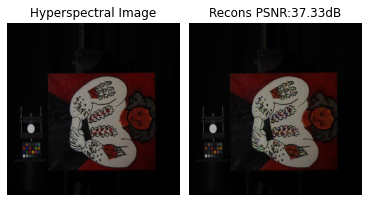

In [11]:
psnr = round( tf.image.psnr(h,h_est,1).numpy()[0],2)

fig, axs = plt.subplots(1,2,constrained_layout=True , figsize=(5,3))
_ = [ x.axis('Off') for x in axs]

axs[0].imshow(h[0,:,:,:][:,:,RGB]) , axs[0].set_title('Hyperspectral Image')
axs[1].imshow(h_est[0,:,:,:][:,:,RGB]) , axs[1].set_title('Recons PSNR:' + str(psnr) + 'dB')

plt.show()